In [44]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

K.clear_session()

In [46]:
tf.__version__[0]

'2'

In [47]:
df = pd.read_csv('data/news.csv')
df.columns = ['id', 'title', 'text', 'label']
df.loc[df.label == 'FAKE', 'label'] = 0
df.loc[df.label == 'REAL', 'label'] = 1
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [48]:
# df.fillna(' ')
df.count()

id       6335
title    6335
text     6335
label    6335
dtype: int64

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [50]:
split = 0.2
split_n = int(round(len(padded)*(1-split), 0))

train_data = np.asarray(padded[:split_n], dtype='float32')
train_labels = np.asarray(df['label'].values[:split_n], dtype='float32')
test_data = np.asarray(padded[split_n:], dtype='float32')
test_labels = np.asarray(df['label'].values[split_n:], dtype='float32')

In [51]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(len(coefs))

100


In [52]:
embeddings_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         9881800   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

In [55]:
history = model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_data=[test_data, test_labels])
print("Training Complete")

Epoch 1/5
51/51 [==============================] - 8s 160ms/step - loss: 0.6200 - accuracy: 0.6622 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
51/51 [==============================] - 8s 147ms/step - loss: 0.5422 - accuracy: 0.7299 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
51/51 [==============================] - 7s 143ms/step - loss: 0.4790 - accuracy: 0.7755 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
51/51 [==============================] - 7s 140ms/step - loss: 0.4133 - accuracy: 0.8129 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
51/51 [==============================] - 7s 146ms/step - loss: 0.3485 - accuracy: 0.8469 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Training Complete


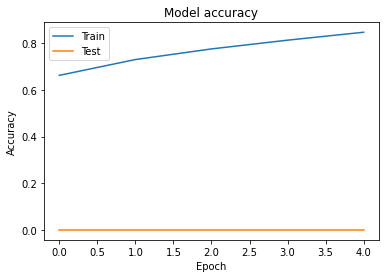

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

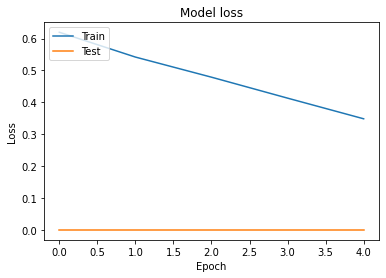

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
model.save('model_saved/my_model')

INFO:tensorflow:Assets written to: model_saved/my_model/assets


In [61]:
test_paragraph = """
The Bank noted that “a high degree of uncertainty” about the near-term outlook for the labor market, following the end of the country’s furlough scheme on Sept. 30, was a key factor in its decision. Unemployment fell to 4.5% in the three months to August while payroll data rose strongly.

“Just over a million jobs are likely to have been furloughed immediately before the Coronavirus Job Retention Scheme closed at end-September, significantly more than expected in the August Report,” the Bank explained.

“Nonetheless, there have continued to be few signs of increases in redundancies and the stock of vacancies has increased further, as have indicators of recruitment difficulties.”

U.K. job vacancies hit a record 1.1 million in the three months to August, while the unemployment rate fell. A tight labor market has been supportive of higher wage growth, a message echoed by business leaders in recent weeks.
"""

test_df = [test_paragraph]

test_sequences = tokenizer.texts_to_sequences(test_df)
test_padded = pad_sequences(test_sequences, maxlen=500, padding='post', truncating='post')
test = np.asarray(test_padded, dtype='float32')
model.predict(test)


array([[0.7672837]], dtype=float32)